This notebook aims at studying mode collapsing when generating MNIST images using GANs.

The structure of the code was largely inspired by this notebook from the [pytorch tutorials on GANs with MNIST](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py) which can be found on github.

# 1. Set-up functions and imports

In [549]:
# IMPORTS
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image
from torch.nn.init import xavier_normal_
import matplotlib.pyplot as plt

In [511]:
device = torch.device('mps')

In [517]:
sample_dir = 'samples'
batch_size = 100

In [513]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 1.1 Loading MNIST

#### 1.1.1 Loading MNIST, size 28

In [514]:
transform_28 = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # for greyscale
                                     std=[0.5])])

In [516]:
# MNIST dataset
mnist_28 = torchvision.datasets.MNIST(root='./data/MNIST_28/',
                                   train=True,
                                   transform=transform_28,
                                   download=True)

In [518]:
data_loader_28 = torch.utils.data.DataLoader(dataset=mnist_28,
                                          batch_size=batch_size, 
                                          shuffle=True)

#### 1.1.2 Loading MNIST, size 64

In [519]:
transform_64 = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(64),
                transforms.Normalize(mean=[0.5],   # for greyscale
                                     std=[0.5])])

In [521]:
# MNIST dataset
mnist_64 = torchvision.datasets.MNIST(root='./data/MNIST_64/',
                                   train=True,
                                   transform=transform_64,
                                   download=True)

In [522]:
data_loader_64 = torch.utils.data.DataLoader(dataset=mnist_64,
                                          batch_size=batch_size, 
                                          shuffle=True)

## 1.2 Useful Functions 

In [524]:
def denorm(x):
    """
    Function to denormalize the normalized outputs of the GANs
    """
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [525]:
def reset_grad(d_optimizer: torch.optim.Optimizer, g_optimizer: torch.optim.Optimizer):
    """
    Function to reset grad at each epoch in the training phase.
    """
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [526]:
def train_normal_gan(
        G: nn.Sequential,
        D: nn.Sequential, 
        d_optimizer: torch.optim.Optimizer, 
        g_optimizer: torch.optim.Optimizer, 
        data_loader: torch.utils.data.DataLoader, 
        num_epochs: int, 
        criterion: nn.modules.BCELoss, 
        device: torch.device, 
        batch_size: int, 
        latent_size: int, 
        sample_dir: str='samples'
    ):
    """
    Function to train a normal GAN on MNIST
    """
    # Start training
    total_step = len(data_loader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            images = images.reshape(batch_size, -1).to(device)
            
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
            d_loss.backward()
            d_optimizer.step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels)
            
            # Backprop and optimize
            reset_grad(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                    .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                            real_score.mean().item(), fake_score.mean().item()))
        
        # Save real images
        if (epoch+1) == 1:
            images = images.reshape(images.size(0), 1, 28, 28)
            save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
        
        # Save sampled images
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

In [550]:
def fake_images_normal_gan(G: nn.Sequential, batch_size: int, latent_size: int, device: torch.device):
    G.eval()
    with torch.no_grad():
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    # plot
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(int(batch_size**0.5), int(batch_size**0.5), i + 1)
        plt.imshow(fake_images[i].squeeze(0).cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

In [528]:
def labels_init(batch_size: int, lab: bool, err: float):
    """
    Function to add some noise in the real labels given to the Discriminator to prevent mode-collapse
    """
    err_labels = int(batch_size*err)
    if lab==1:
        x = torch.cat((torch.ones((batch_size-err_labels,1)), torch.zeros((err_labels,1))), 0)
    else:
        x = torch.cat((torch.zeros((batch_size-err_labels,1)), torch.ones((err_labels,1))), 0)
    y = x[torch.randperm(batch_size)].to(device)
    return y

In [529]:
def train_cnn_gan(
        G: nn.Sequential,
        D: nn.Sequential, 
        d_optimizer: torch.optim.Optimizer, 
        g_optimizer: torch.optim.Optimizer, 
        data_loader: torch.utils.data.DataLoader, 
        num_epochs: int,
        criterion: nn.modules.BCELoss, 
        device: torch.device, 
        batch_size: int, 
        latent_size: int, 
        sample_dir: str='samples',
        epsilon: float=0.0,
    ):
    """
    Function to train a CNN GAN on MNIST, with a possibility to use noisy labels to prevent mode-collapse (percentage
    of noisy labels introduced in both fake and real labels to the Discriminator is as large as epsilon).
    """
    # Start training
    total_step = len(data_loader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)
            
            # Create the labels which are later used as input for the BCE loss, add noise if epsilon > 0
            real_labels = labels_init(batch_size, 1, epsilon)
            fake_labels = labels_init(batch_size, 0, epsilon)

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images).view(-1, 1)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(batch_size, latent_size, 1, 1).to(device)
            fake_images = G(z)
            outputs = D(fake_images).squeeze(1).squeeze(1)

            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
            d_loss.backward()
            d_optimizer.step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #
            
            # Compute loss with fake images
            z = torch.randn(batch_size, latent_size, 1, 1).to(device)
            fake_images = G(z)
            outputs = D(fake_images).squeeze(1).squeeze(1)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels)
            
            # Backprop and optimize
            reset_grad(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                    .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                            real_score.mean().item(), fake_score.mean().item()))
        
        # Save real images
        if (epoch+1) == 1:
            # images = images.reshape(images.size(0), 1, 28, 28)
            save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
        
        # Save sampled images
        # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fake_images = fake_images
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

In [554]:
def fake_images_cnn_gan(G: nn.Sequential, batch_size: int, latent_size: int, device: torch.device):
    G.eval()
    with torch.no_grad():
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        fake_images = G(z)

    # plot
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(int(batch_size**0.5), int(batch_size**0.5), i + 1)
        plt.imshow(fake_images[i].squeeze(0).cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

## 1.3 Useful Variables

In [536]:
# "Normal" GAN hyperparameters
hidden_size = 256
image_size = 784

# CNN based GAN hyperparameters
filters_g = 64
filters_d = 64

# 2. Generating fake MNIST images using a "Normal" GAN

## 2.1. Model architecture

In [537]:
latent_size = 64
num_epochs = 200

In [530]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [556]:
# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [532]:
# Device setting
D = D.to(device)
G = G.to(device)

In [533]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

## 2.2. Loading vs Training the GAN

### 2.2.1 Loading

Skip these cells if you want to wait a looonnnng time and actually train the model...

In [535]:
# Load the checkpoint files
d_checkpoint = torch.load('models/D_normal.ckpt', weights_only=True)
g_checkpoint = torch.load('models/G_normal.ckpt', weights_only=True)

# Load the weights into the models
D.load_state_dict(d_checkpoint)
G.load_state_dict(g_checkpoint)

print("Models successfully loaded!")

Models successfully loaded!


### 2.2.2 Training

Skip these cells if you don't want to wait a lonnnng time...

In [ ]:
train_normal_gan(G, D, d_optimizer, g_optimizer, data_loader_28, num_epochs, criterion, device, batch_size, latent_size, sample_dir="samples/normal_gan")

In [ ]:
# don't forget to save this beautiful model
torch.save(G.state_dict(), 'models/G_normal_gan.ckpt')
torch.save(D.state_dict(), 'models/D_normal_gan.ckpt')

## 2.3 Images and Analysis

### 2.3.1 Evolution through epochs

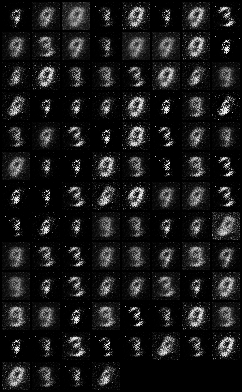

In [540]:
Image('./samples/normal_gan/fake_images-10.png') # Epoch 10

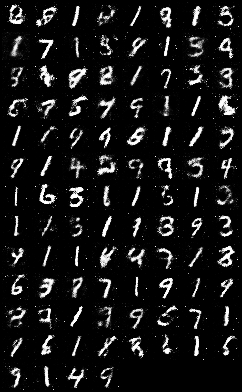

In [541]:
Image('./samples/normal_gan/fake_images-100.png') # Epoch 100

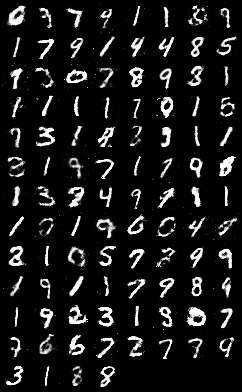

In [542]:
Image('./samples/normal_gan/fake_images-200.png') # Epoch 200

### 2.3.2 Analysis

You can have fun with the cells below and generate some random images:

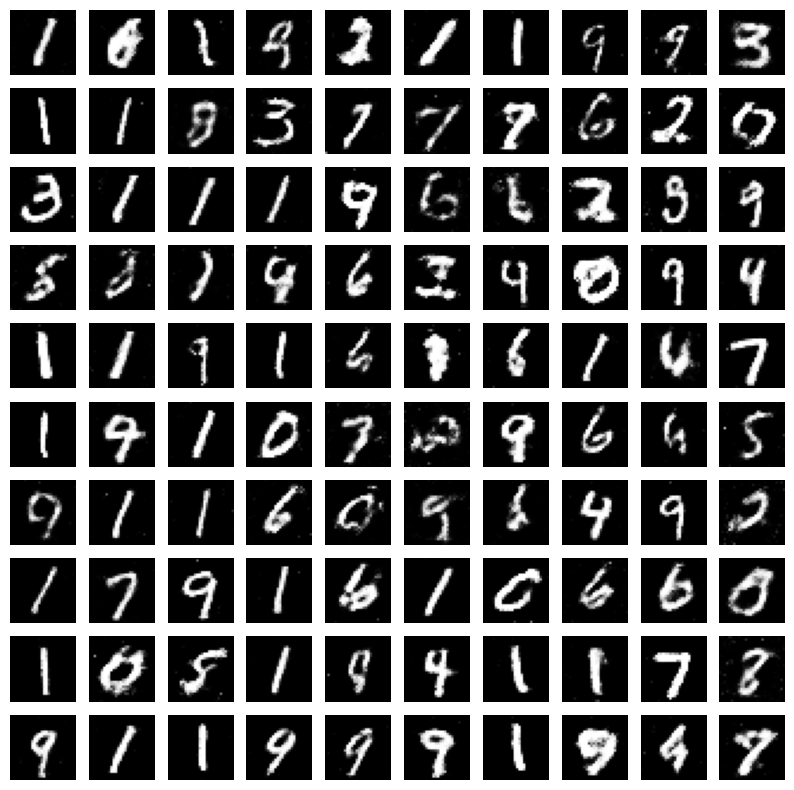

In [553]:
fake_images_normal_gan(G, batch_size, latent_size, device)

To be honest, for a GAN that has such a simple architecture, we can be quite proud of how well it performs. However, it doesn't really show us when it collapses. This will be done in the following section.

# 3. Mode collapse in GAN using MNIST and Convolution Layers

The structure of the GAN was taken from [this github repo](https://github.com/rohitpatwa/gans-mode-collapse/tree/main). Furthermore, the technique used to avoid this phenomena was also inspired by the work found inside the notebook.

## 3.1 Model architecture

In [555]:
latent_size = 64
num_epochs = 25

In [558]:
# Generator
G = nn.Sequential(
    nn.ConvTranspose2d(latent_size, filters_g * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(filters_g * 8),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 8, filters_g * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g * 4),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 4, filters_g * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g * 2),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 2, filters_g, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g, 1, 4, 2, 1, bias=False),
    nn.Tanh()
)

In [559]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(1, filters_d, 4, 2, 1, bias=False),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d, filters_d * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 2),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 2, filters_d * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 4),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 4, filters_d * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 8),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
)

In [560]:
# Device setting
D = D.to(device)
G = G.to(device)

In [561]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

## 3.2. Loading vs Training the GAN

### 3.2.1 Loading

Skip these cells if you want to wait a looonnnng time and actually train the model...

In [564]:
# Load the checkpoint files
d_checkpoint = torch.load('models/D_cnn_collapse.ckpt', weights_only=True, map_location=device)
g_checkpoint = torch.load('models/G_cnn_collapse.ckpt', weights_only=True, map_location=device)

# Load the weights into the models
D.load_state_dict(d_checkpoint)
G.load_state_dict(g_checkpoint)

print("Models successfully loaded!")

Models successfully loaded!


### 3.2.2 Training

Skip these cells if you don't want to wait a lonnnng time...

In [ ]:
train_cnn_gan(G, D, d_optimizer, g_optimizer, data_loader_64, num_epochs, criterion, device, batch_size, latent_size, sample_dir="samples/cnn_collapse_gan")

In [ ]:
# don't forget to save this beautiful model
torch.save(G.state_dict(), 'models/G_cnn_collapse.ckpt')
torch.save(D.state_dict(), 'models/D_cnn_collapse.ckpt')

## 3.3 Images and Analysis

### 3.3.1 Evolution through epochs

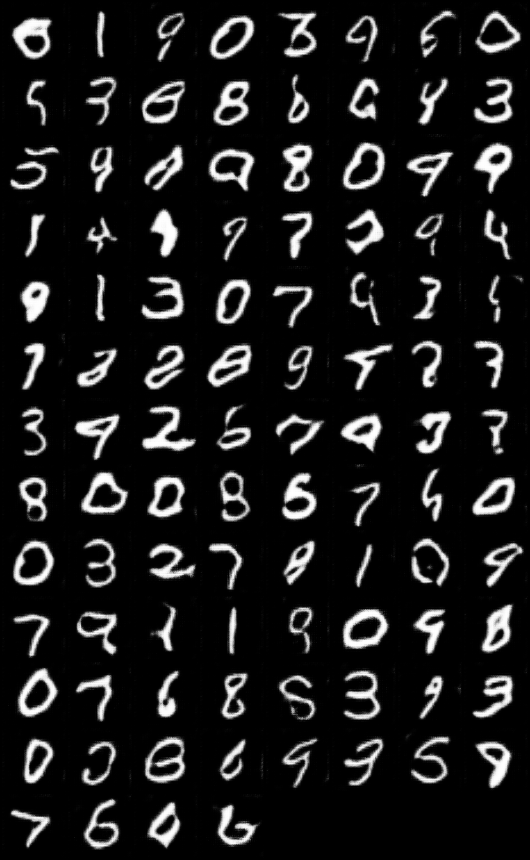

In [565]:
Image('./samples/cnn_collapse_gan/fake_images-10.png') # Epoch 10

At first glance, the model seemed to learn quite well the digits, and the 10th epoch was much better than the 10th epoch of the more simpler model above.

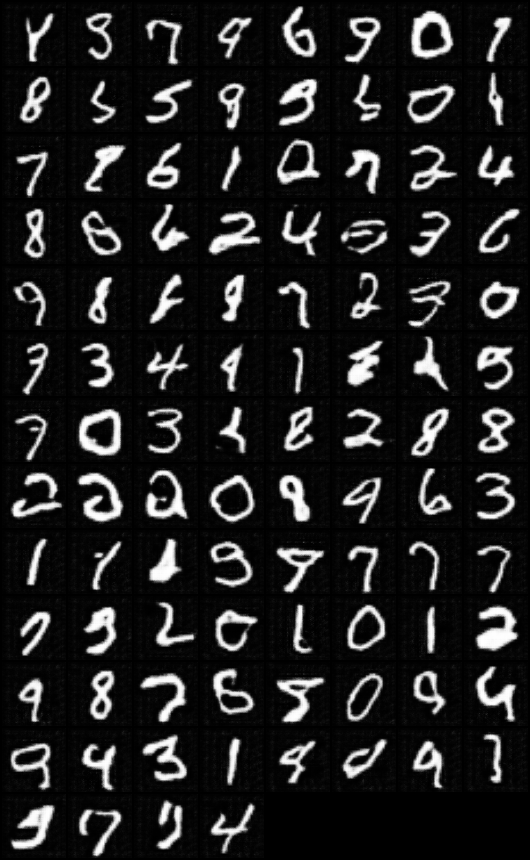

In [567]:
Image('./samples/cnn_collapse_gan/fake_images-18.png') # Epoch 18

However, starting at epoch 19, the model seemed to start going off course.

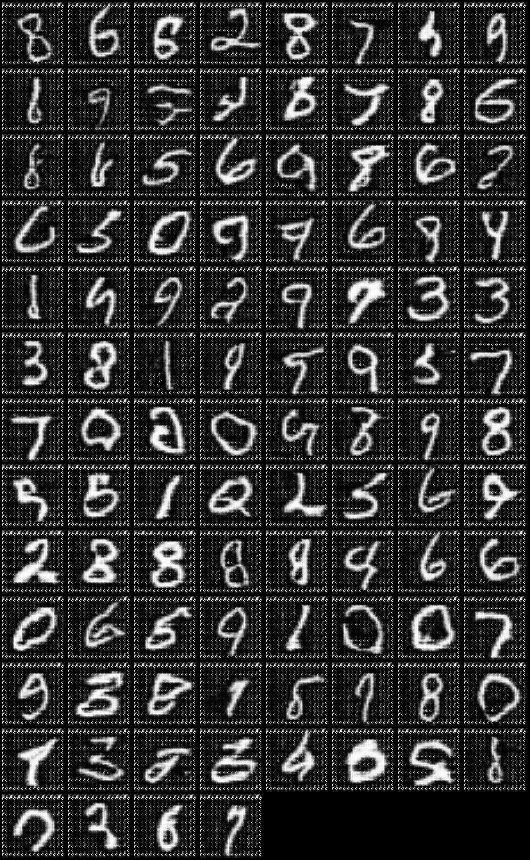

In [568]:
Image('./samples/cnn_collapse_gan/fake_images-19.png') # Epoch 19

At epoch 20, the model had switched into a mode collapse phenomena, the discriminator was not strong enough to penalize the generator and get out of this "saddle point" in the optimization process where the generator could just replicate the same pattern over and over and fool the discriminator.

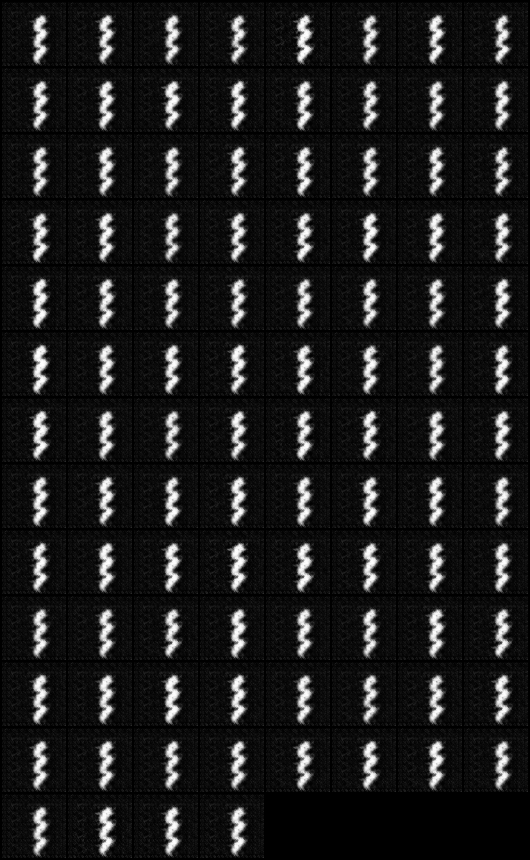

In [569]:
Image('./samples/cnn_collapse_gan/fake_images-20.png') # Epoch 20

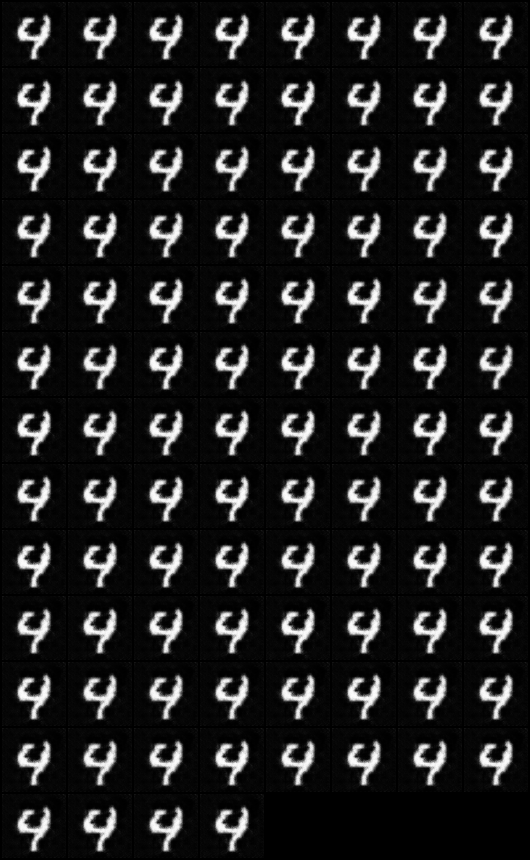

In [571]:
Image('./samples/cnn_collapse_gan/fake_images-24.png') # Epoch 24

### 3.3.2 Analysis

You can have fun with the cells below and generate some random images:

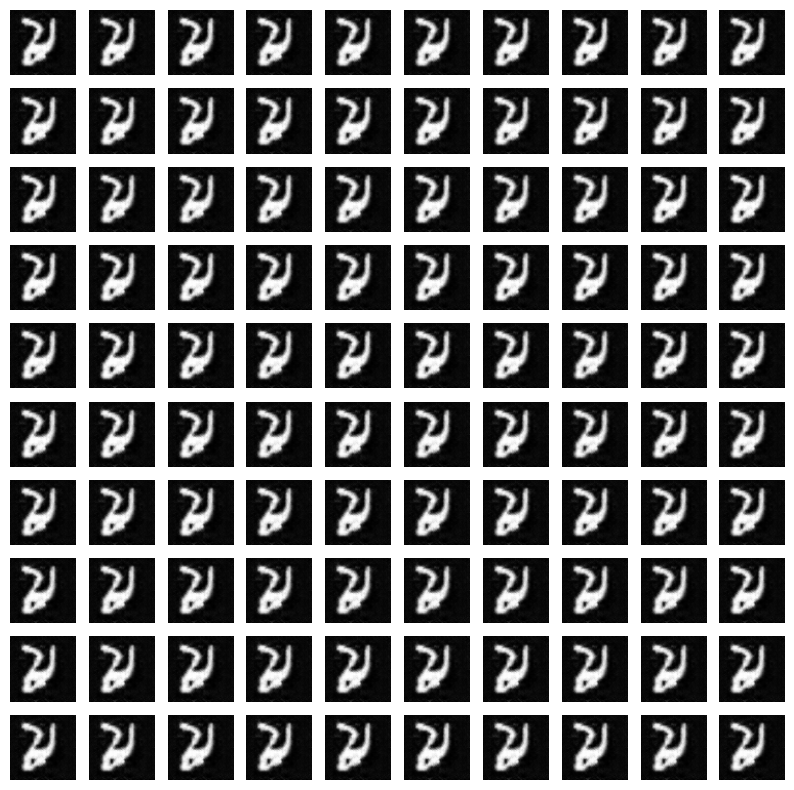

In [574]:
fake_images_cnn_gan(G, batch_size, latent_size, device)

The model just keeps outputting the same ridiculous image, is it a rabbit?

# 4. Avoiding mode collapse in GAN using MNIST and Convolution Layers

The structure of the GAN was taken from [this github repo](https://github.com/rohitpatwa/gans-mode-collapse/tree/main). Furthermore, the technique used to avoid this phenomena was also inspired by the work found inside the repo.

But first, let us introduce what mode collapse really is. Mode collapse in a Generative Adversarial Network occurs when the generator learns to produce a limited variety of outputs that the discriminator consistently misclassifies as "real," neglecting the diversity of the data distribution. This happens due to the adversarial nature of GAN training, where the generator focuses too narrowly on fooling the discriminator rather than learning a complete representation of the data distribution.

The technique in question was inspired by these two papers according to the authors:
- [NIPS 2016 Tutorial: Generative Adversarial Networks by Ian Goodfellow](https://arxiv.org/pdf/1701.00160.pdf)
- [ON CONVERGENCE AND STABILITY OF GANS by Naveen Kodali, Jacob Abernethy, James Hays Zsolt Kira](https://arxiv.org/pdf/1705.07215.pdf)

The idea is to avoid overfitting on the discriminator by adding noisy labels in the training procedure. This means that instead of giving all of the real data a real label (say $0$), we flip (by a factor of $\epsilon$) some of the real labels to the fake label (say $1$). Conversely, instead of giving all of the fake data a fake label (say $1$), we flip (by a factor of $\epsilon$) some of the fake labels to the real label (say $0$).

This technique is well known, and works for several reasons. First, this prevents the discriminator from becoming overly confident in distinguishing between real and fake data. Second, it encourages the generator to be more diverse and explore other subsets of the data, allowing for better coverage of the data distribution. Third, this technique simulates imperfections in real-world datasets, setting a more diverse environment and thus leading to a more robust GAN.

## 4.1 Model architecture

In [575]:
latent_size = 64
num_epochs = 30

In [576]:
# Generator
G = nn.Sequential(
    nn.ConvTranspose2d(latent_size, filters_g * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(filters_g * 8),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 8, filters_g * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g * 4),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 4, filters_g * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g * 2),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g * 2, filters_g, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_g),
    nn.LeakyReLU(inplace=True),
    
    nn.ConvTranspose2d(filters_g, 1, 4, 2, 1, bias=False),
    nn.Tanh()
)

In [577]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(1, filters_d, 4, 2, 1, bias=False),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d, filters_d * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 2),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 2, filters_d * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 4),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 4, filters_d * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters_d * 8),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    
    nn.Conv2d(filters_d * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
)

In [578]:
# Device setting
D = D.to(device)
G = G.to(device)

In [579]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

## 4.2. Loading vs Training the GAN

### 4.2.1 Loading

Skip these cells if you want to wait a looonnnng time and actually train the model...

In [585]:
# Load the checkpoint files
d_checkpoint = torch.load('models/D_cnn_noisy.ckpt', weights_only=True, map_location=device)
g_checkpoint = torch.load('models/G_cnn_noisy.ckpt', weights_only=True, map_location=device)

# Load the weights into the models
D.load_state_dict(d_checkpoint)
G.load_state_dict(g_checkpoint)

print("Models successfully loaded!")

Models successfully loaded!


### 4.2.2 Training

Skip these cells if you don't want to wait a lonnnng time...

In [ ]:
# DON'T FORGET EPSILON!!
train_cnn_gan(G, D, d_optimizer, g_optimizer, data_loader_64, num_epochs, criterion, device, batch_size, latent_size, sample_dir="samples/cnn_noisy_gan", epsilon=0.05)

In [ ]:
# don't forget to save this beautiful model
torch.save(G.state_dict(), 'models/G_cnn_noisy.ckpt')
torch.save(D.state_dict(), 'models/D_cnn_noisy.ckpt')

## 4.3 Images and Analysis

### 4.3.1 Evolution through epochs

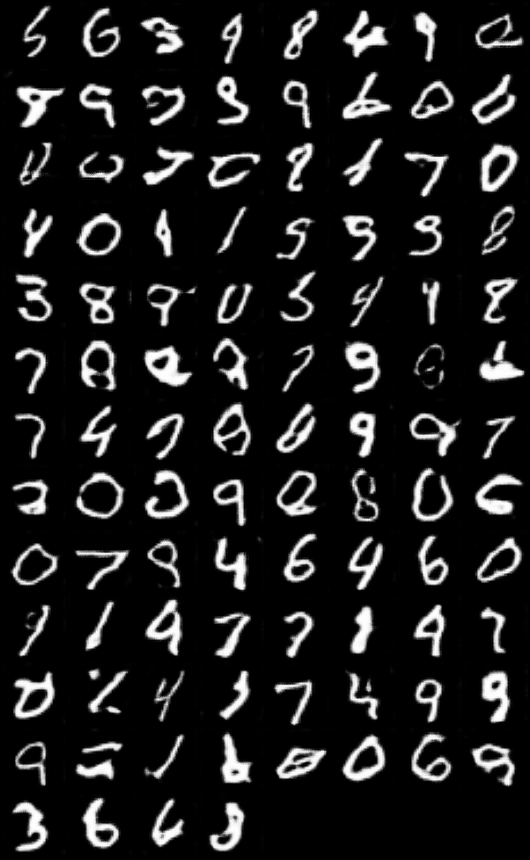

In [580]:
Image('./samples/cnn_noisy_gan/fake_images-10.png') # Epoch 10

At the 10th epoch, it seems like the model has less well learned the representation of the data than the second model introduced in this notebook.

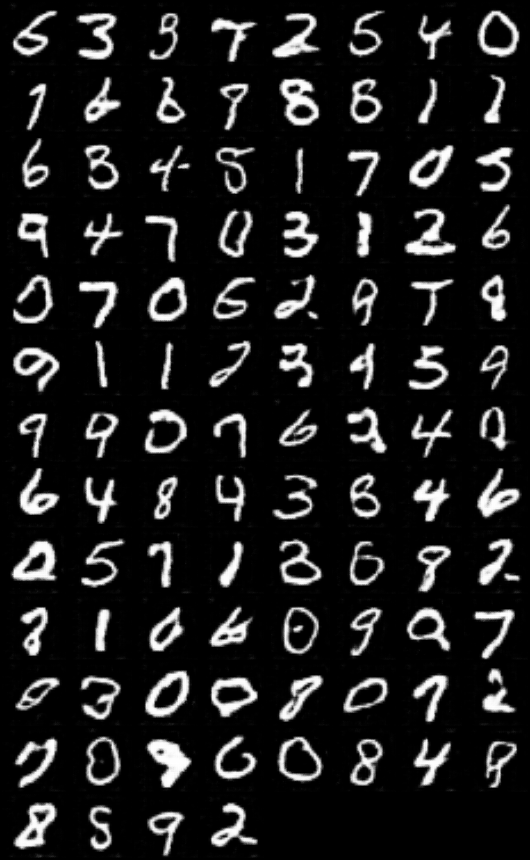

In [581]:
Image('./samples/cnn_noisy_gan/fake_images-20.png') # Epoch 20

However, starting at epoch 20, the model has not gone off-course yet, and the representations seem quite good.

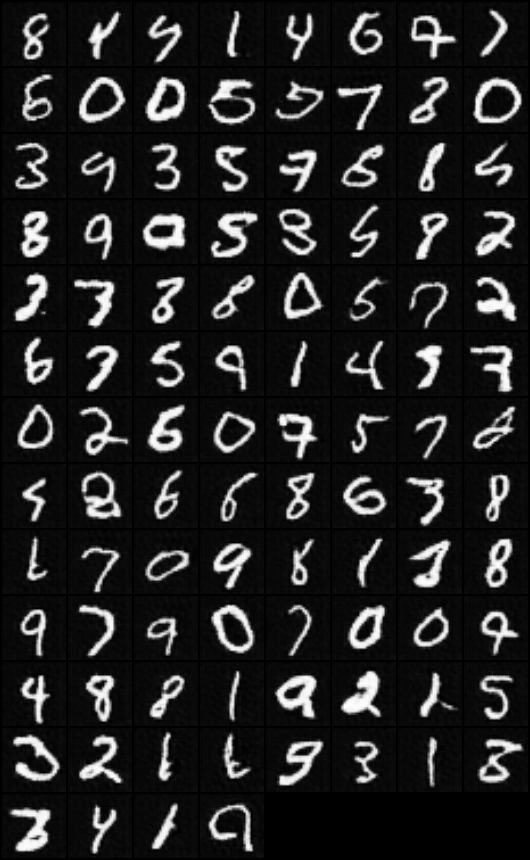

In [582]:
Image('./samples/cnn_noisy_gan/fake_images-30.png') # Epoch 30

At epoch 30, the representations are really excellent, and we could train for even longer to get almost perfect images. Additionaly, the data seems very diverse, with not too many repetitions of digist that are easier to represent (like ones), which usually is the case.

### 4.3.2 Analysis

You can have fun with the cells below and generate some random images:

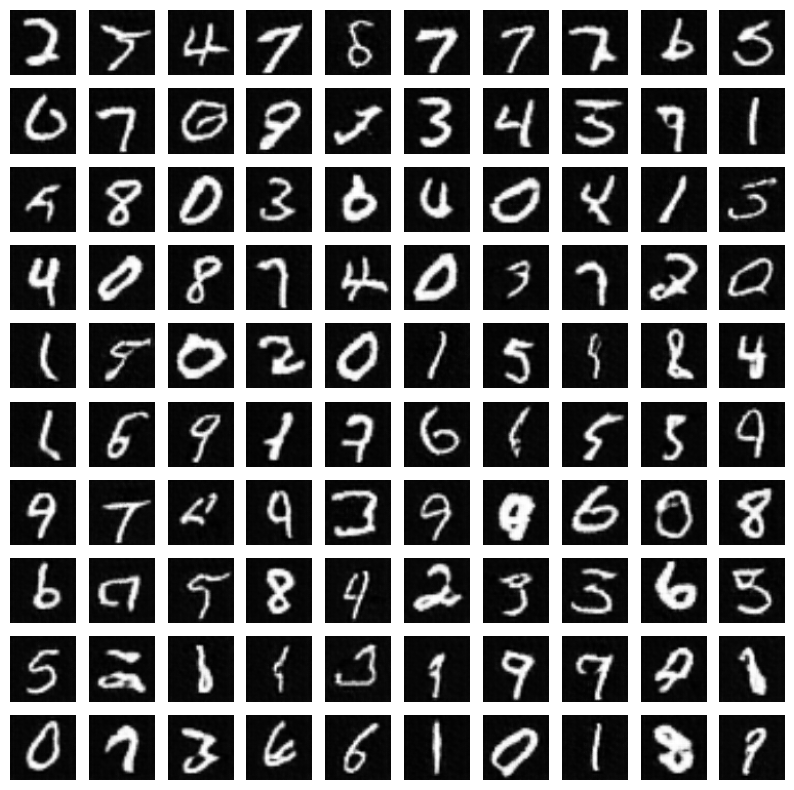

In [587]:
fake_images_cnn_gan(G, batch_size, latent_size, device)

The GAN did not mode collapse, and it actually learned the representations quite well. I would say this is pretty good!

# 5. Conclusion

In conclusion, finding an architecture to get mode collapse was trickier than we first envisionned. Either the models were working perfectly fine (or we didn't have the computational power to run more epochs) or they simply collapsed (and not mode collapsed). GANs are quite unstable, and techniques like unbalancing the Discriminator over the Generator (and vice-versa) were really tricky to work with and we didn't manage to get mode collapse out of it. Changing the hyperparameters (e.g. giving the Discriminator a high learning rate compared to the Generator) lead to similar conclusions. Furthermore, over training the Generator seemed to give interesting results, but it wasn't perfect mode collapse and felt like doing some artificially generated mode-collapse (which we could've talked about in this notebook, but it would've been too long).

Moreover, we didn't have time to implement metrics to catch mode collapsing when needed, but ideas would have been to check for diversity between generated images and stop the process at a threshold using this metric. Another metric could have been to check for noise generated, as we saw in the multitude of GANs used that sometimes the model collapsed by just outputting some noise at the center of the image.

Finally, techniques like GANs using the Wasserstein distance, or InfoGANs (i.e. conditional GANs) were interesting to bring stability and were investigated but not shown for time and space issues (sorry... :) ).

# 6. BONUS - Art Gallery

Is it Wall-e?

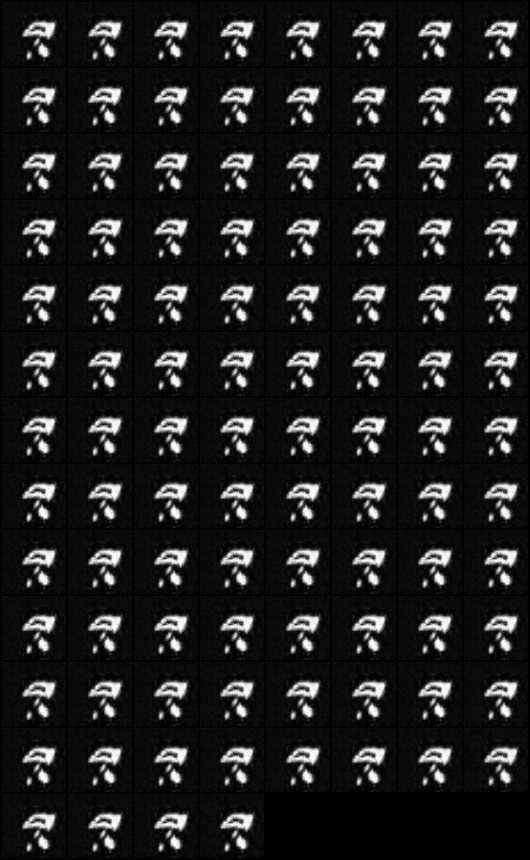

In [588]:
Image('./samples/cnn_collapse_gan/fake_images-25.png') # Epoch 25

Tire-bouchon?

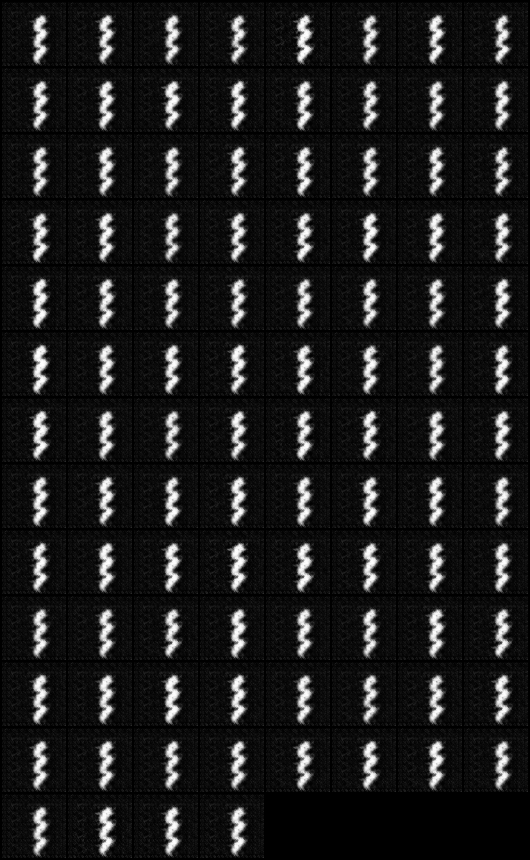

In [597]:
Image('./samples/cnn_collapse_gan/fake_images-20.png') # Epoch 20

Dragonnet? Iguane? Lézard?

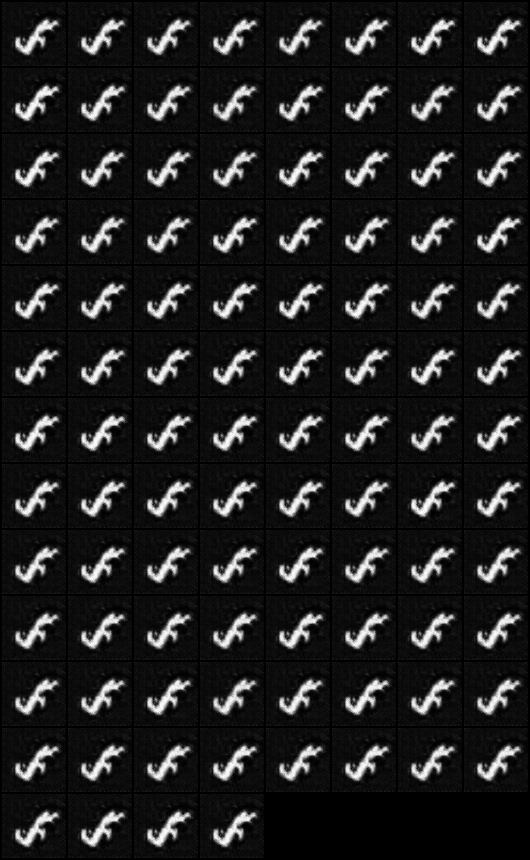

In [596]:
Image('./samples/cnn_collapse_gan/fake_images-23.png') # Epoch 23